# 383: Project

## Team
1) lunavarro@csumb.edu
2) josalvarado@csumb.edu
3) cgriffiths@csumb.edu
4) adoolan@csumb.edu

## Title 
Predicting Water Suface Elevation in Ground Water

## Authors
Jose Alvarado
Cory Griffiths
Luis Navarro
Anthony Doolan

## Introduction
The dataset contains information about “Continuous groundwater level measurements aggregated to monthly time step.” It dates from December 1, 1969, through January 1, 2023. There are many stations in the data set, and each station can provide a groundwater measurement relative to the sea level and the station's elevation. There are 5 ways in which the water level is measured. This should help increase the quality of measurement when a particular device malfunctions. Each type of measurement comes with information about the quality control of the mechanism. The quality control appears to be good when the value is 1 and invalid when it is 255.

## What we are Trying to Predict
We can try to predict what the water level of the next 5 years will be for either 1 or a few measurement locations. For example station 21N02E26E005M has over 50 measurements going back to the 70's. This station has the most data that can predict what next years level is going to be. Take a look at the sectiion __"Graping the water Levels"__, you can see the cyclic variance of the water levels over the course of measurements. The cyclic nature of the measurements can be used to predict what next years water level will be based on the previous few years.

## Features
We are going to use the MSMT_DATE and STATION as the predictors for the water level. We need to convert the MSMT_DATE to a timestamp though.





## Preliminary work on data preparation

### Column Information
* __STATION__: ID of the station, use var stations to get info based on id.
* __MSMT_DATE__: Date the measurement was taken. YYYY-MM-DD
* __WLM_RPE__: Water Level relative to reference point
* __WLM_RPE_QC__: Quality Control for above
* __WLM_GSE__: Water Level relative to ground surface elevation
* __WLM_GSE_QC__: Quality Control for above
* __RPE_WSE__: Water Surface Elevation relative to reference point
* __RPE_WSE_QC__: Quality Control for above
* __GSE_WSE__: Water surface elevation relative to ground surface elevation.
* __GSE_WSE_QC__: Quality Control for above
* __WSE__: water surface elevation
* __WSE_QC__: Quality Control for above

In [338]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [305]:
# set default figure size
plt.rcParams['figure.figsize'] = [8.0, 6.0]

In [306]:
# code in this cell from: 
# https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
    const inputWrappers = document.querySelectorAll('.jp-CodeCell .jp-Cell-inputWrapper');
    if (code_show){
        for (let i = 0; i < inputWrappers.length; i++) {
            inputWrappers[i].style.display = 'none';
        }
    } else {
        for (let i = 0; i < inputWrappers.length; i++) {
            inputWrappers[i].style.display = 'block';
        }
    }
    code_show = !code_show
} 

</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>''')


### Reading the Data

In [307]:

data = "https://data.cnra.ca.gov/dataset/618c73fe-b28c-4399-a824-43d0278fe974/resource/16f256f8-35a4-4cab-ae02-399a2914c282/download/gwl-monthly.csv"
df = pd.read_csv(data)

In [308]:
stations = pd.read_csv("https://data.cnra.ca.gov/dataset/618c73fe-b28c-4399-a824-43d0278fe974/resource/03967113-1556-4100-af2c-b16a4d41b9d0/download/gwl-stations.csv")
quality_codes = pd.read_csv("https://data.cnra.ca.gov/dataset/618c73fe-b28c-4399-a824-43d0278fe974/resource/06437a09-ac72-4d5b-91a7-e5963349b486/download/gwl-quality_codes.csv")

In [309]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81518 entries, 0 to 81517
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STATION     81518 non-null  object 
 1   MSMT_DATE   81518 non-null  object 
 2   WLM_RPE     81288 non-null  float64
 3   WLM_RPE_QC  81518 non-null  int64  
 4   WLM_GSE     80945 non-null  float64
 5   WLM_GSE_QC  81518 non-null  int64  
 6   RPE_WSE     66201 non-null  float64
 7   RPE_WSE_QC  81518 non-null  int64  
 8   GSE_WSE     65686 non-null  float64
 9   GSE_WSE_QC  81518 non-null  int64  
 10  WSE         65985 non-null  float64
 11  WSE_QC      81518 non-null  int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 7.5+ MB


In [310]:
df.describe()

,WLM_RPE,WLM_RPE_QC,WLM_GSE,WLM_GSE_QC,RPE_WSE,RPE_WSE_QC,GSE_WSE,GSE_WSE_QC,WSE,WSE_QC
count,81288.000000,81518.000000,80945.000000,81518.000000,66201.000000,81518.000000,65686.000000,81518.000000,65985.000000,81518.000000
mean,340.989135,9.188596,339.961640,9.445816,36.468327,47.844599,34.694826,55.202090,301.536859,54.627469
std,971.396485,27.503044,973.278407,28.782817,33.718321,96.862387,33.863122,97.041351,982.856723,96.934063
min,-0.570000,1.000000,-3.170000,1.000000,-11.949000,1.000000,-14.749000,1.000000,-165.659000,1.000000
25%,45.010000,1.000000,44.580000,1.000000,12.900000,1.000000,11.361000,1.000000,20.672000,1.000000
50%,132.980000,1.000000,129.300000,1.000000,26.054000,1.000000,24.270000,1.000000,95.323000,1.000000
75%,208.220000,1.000000,212.410000,1.000000,49.483000,1.000000,47.857500,70.000000,148.335000,70.000000
max,5495.260000,255.000000,5492.010000,255.000000,316.157000,255.000000,314.037000,255.000000,5491.840000,255.000000


### Missing Data

In [311]:
print(df.isnull().sum())
df[df['RPE_WSE'].isnull()]
df[df['GSE_WSE'].isnull()]
df[df['WSE'].isnull()]

STATION           0
MSMT_DATE         0
WLM_RPE         230
WLM_RPE_QC        0
WLM_GSE         573
WLM_GSE_QC        0
RPE_WSE       15317
RPE_WSE_QC        0
GSE_WSE       15832
GSE_WSE_QC        0
WSE           15533
WSE_QC            0
dtype: int64


,STATION,MSMT_DATE,WLM_RPE,WLM_RPE_QC,WLM_GSE,WLM_GSE_QC,RPE_WSE,RPE_WSE_QC,GSE_WSE,GSE_WSE_QC,WSE,WSE_QC
0,01N04E36Q001M,2005-04-01,9.10,1,6.90,1,NaN,255,NaN,255,NaN,255
37,01N04E36Q001M,2008-05-01,9.10,1,6.90,1,NaN,255,NaN,255,NaN,255
38,01N04E36Q001M,2008-06-01,9.10,1,6.90,1,NaN,255,NaN,255,NaN,255
39,01N04E36Q001M,2008-07-01,9.10,1,6.90,1,NaN,255,NaN,255,NaN,255
40,01N04E36Q001M,2008-08-01,9.10,1,6.90,1,NaN,255,NaN,255,NaN,255
...,...,...,...,...,...,...,...,...,...,...,...,...
81496,48N05E36A002M,2001-09-01,4139.98,1,4138.48,1,NaN,255,NaN,255,NaN,255
81514,48N05E36A002M,2003-03-01,4139.98,1,4138.48,1,NaN,151,NaN,151,NaN,151
81515,48N05E36A002M,2003-04-01,4139.98,1,4138.48,1,NaN,151,NaN,151,NaN,151
81516,48N05E36A002M,2003-05-01,4139.98,1,4138.48,1,NaN,151,NaN,151,NaN,151


We can drop the na values for now? Its a fraction of the data.

In [312]:
len(df)
df = df.dropna()
len(df)


65686

In [313]:
df.info()
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65686 entries, 1 to 81513
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STATION     65686 non-null  object 
 1   MSMT_DATE   65686 non-null  object 
 2   WLM_RPE     65686 non-null  float64
 3   WLM_RPE_QC  65686 non-null  int64  
 4   WLM_GSE     65686 non-null  float64
 5   WLM_GSE_QC  65686 non-null  int64  
 6   RPE_WSE     65686 non-null  float64
 7   RPE_WSE_QC  65686 non-null  int64  
 8   GSE_WSE     65686 non-null  float64
 9   GSE_WSE_QC  65686 non-null  int64  
 10  WSE         65686 non-null  float64
 11  WSE_QC      65686 non-null  int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 6.5+ MB
STATION       0
MSMT_DATE     0
WLM_RPE       0
WLM_RPE_QC    0
WLM_GSE       0
WLM_GSE_QC    0
RPE_WSE       0
RPE_WSE_QC    0
GSE_WSE       0
GSE_WSE_QC    0
WSE           0
WSE_QC        0
dtype: int64


### Station Info

In [314]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551 entries, 0 to 550
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   STATION      551 non-null    object 
 1   SITE_CODE    540 non-null    object 
 2   STNAME       551 non-null    object 
 3   WELL_NAME    551 non-null    object 
 4   LATITUDE     551 non-null    float64
 5   LONGITUDE    551 non-null    float64
 6   LLDATUM      551 non-null    object 
 7   POSACC       551 non-null    object 
 8   ELEV         551 non-null    float64
 9   ELEVDATUM    87 non-null     object 
 10  ELEVACC      551 non-null    object 
 11  COUNTY_NAME  551 non-null    object 
 12  BASIN_CODE   536 non-null    object 
 13  BASIN_NAME   536 non-null    object 
 14  WELL_DEPTH   523 non-null    float64
 15  WELL_USE     526 non-null    object 
 16  WELL_TYPE    536 non-null    object 
 17  WCR_NO       398 non-null    object 
 18  WDL          551 non-null    object 
 19  COMMENT 

### Quality Control Info

In [315]:
quality_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   QUALITY_CODE  45 non-null     int64 
 1   DESCRIPTION   45 non-null     object
dtypes: int64(1), object(1)
memory usage: 848.0+ bytes


## Preliminary work on data exploration and visualization

### Helper Functions to filter by date

In [316]:

def get_mst_by_year(df, year):
    return df[df['MSMT_DATE'].str.startswith(year)]

def get_mst_by_month(df, month):
    return df[df['MSMT_DATE'].str[5:].str.startswith(month)]

def get_mst_by_month_year(df, month, year):
    return df[df['MSMT_DATE'].str.startswith(year + '-' + month)]


### Highest water level recorded in 2005

In [317]:
y2005 = get_mst_by_year(df, '2005')
print(y2005.max())

STATION       48N05E26D001M
MSMT_DATE        2005-12-01
WLM_RPE             5495.26
WLM_RPE_QC               70
WLM_GSE             5492.01
WLM_GSE_QC               70
RPE_WSE             203.254
RPE_WSE_QC               70
GSE_WSE             201.284
GSE_WSE_QC               70
WSE                5489.487
WSE_QC                   70
dtype: object


### Highest Recorded Water Level in December

In [318]:
dec = get_mst_by_month(df, '12')
print(dec.max())

STATION       48N05E36A002M
MSMT_DATE        2022-12-01
WLM_RPE             5495.26
WLM_RPE_QC              130
WLM_GSE             5492.01
WLM_GSE_QC              130
RPE_WSE             249.449
RPE_WSE_QC              120
GSE_WSE             246.829
GSE_WSE_QC              130
WSE                5491.607
WSE_QC                  130
dtype: object


### Max Level in December 2005

In [319]:
dec_2005 = get_mst_by_month_year(df, '12', '2005')
print(dec_2005.max())

STATION       48N05E26D001M
MSMT_DATE        2005-12-01
WLM_RPE             5495.26
WLM_RPE_QC               70
WLM_GSE             5492.01
WLM_GSE_QC               70
RPE_WSE             149.485
RPE_WSE_QC               10
GSE_WSE             147.985
GSE_WSE_QC               70
WSE                5489.487
WSE_QC                   70
dtype: object


## Water level of station 48N05E26D001M over 2005

In [320]:
print(get_mst_by_year(df[df['STATION'] == '48N05E26D001M'], '2005')[['MSMT_DATE', 'WSE', 'WSE_QC']])

        MSMT_DATE       WSE  WSE_QC
81449  2005-01-01  4011.179       1
81450  2005-02-01  4011.453       1
81451  2005-03-01  4011.560       1
81452  2005-04-01  4011.785       1
81453  2005-05-01  4012.024       1
81454  2005-06-01  3989.853       1
81455  2005-07-01  4011.226       1
81456  2005-08-01  4011.034       1
81457  2005-09-01  4010.845       1
81458  2005-10-01  4010.657       1
81459  2005-11-01  4010.468       1
81460  2005-12-01  4010.279       1


## View Number of yearly measurements per station.

In [321]:
print(get_mst_by_month(df, '01')[['STATION', 'MSMT_DATE', 'WSE', 'WSE_QC']].value_counts('STATION'))


STATION
21N02E26E005M         52
09N03E08C001M         29
11N04E04N004M         29
09N03E08C003M         29
11N04E04N003M         28
                      ..
12N02E33P003M          1
387507N1216346W001     1
387627N1216358W001     1
30N04W10H002M          1
11N01E24Q501M          1
Length: 510, dtype: int64


## View Station 21N02E26E005M

             STATION   MSMT_DATE  WLM_RPE  WLM_RPE_QC  WLM_GSE  WLM_GSE_QC  \
47155  21N02E26E005M  1970-01-01   184.44          10   182.26          10   
47167  21N02E26E005M  1971-01-01   184.44          10   182.26          10   
47179  21N02E26E005M  1972-01-01   184.44          10   182.26          10   
47191  21N02E26E005M  1973-01-01   184.44          10   182.26          10   
47203  21N02E26E005M  1974-01-01   184.44          10   182.26          10   
47215  21N02E26E005M  1975-01-01   184.44          10   182.26          10   
47227  21N02E26E005M  1976-01-01   184.44          10   182.26          10   
47239  21N02E26E005M  1977-01-01   184.44          10   182.26          10   
47251  21N02E26E005M  1978-01-01   184.44          10   182.26          10   
47263  21N02E26E005M  1979-01-01   184.44          10   182.26          10   
47275  21N02E26E005M  1980-01-01   184.44          10   182.26          10   
47287  21N02E26E005M  1981-01-01   184.44          10   182.26  

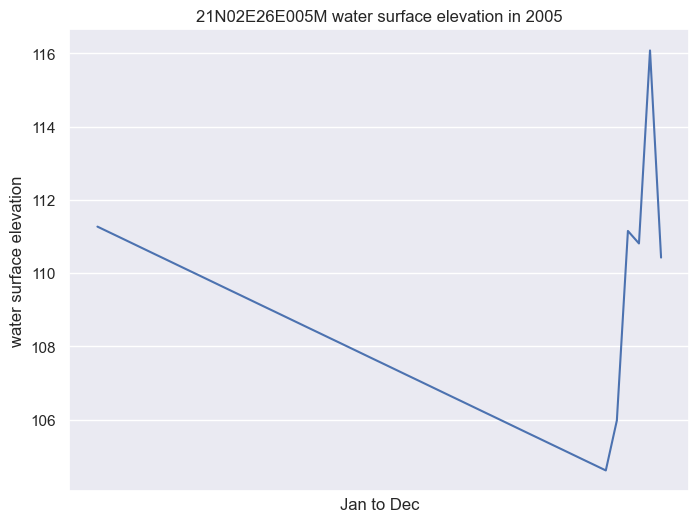

In [322]:

historic_station_levels = get_mst_by_month(df[df['STATION'] == '21N02E26E005M'], '01')
print(historic_station_levels)
plt.xticks([])
plt.title('21N02E26E005M water surface elevation in 2005')
plt.ylabel('water surface elevation')
plt.xlabel('Jan to Dec')
plt.plot(get_mst_by_month(df[df['STATION'] == '21N02E26E005M'], '01')['MSMT_DATE'], get_mst_by_month(df[df['STATION'] == '21N02E26E005M'], '01')['WSE'])
plt.show()

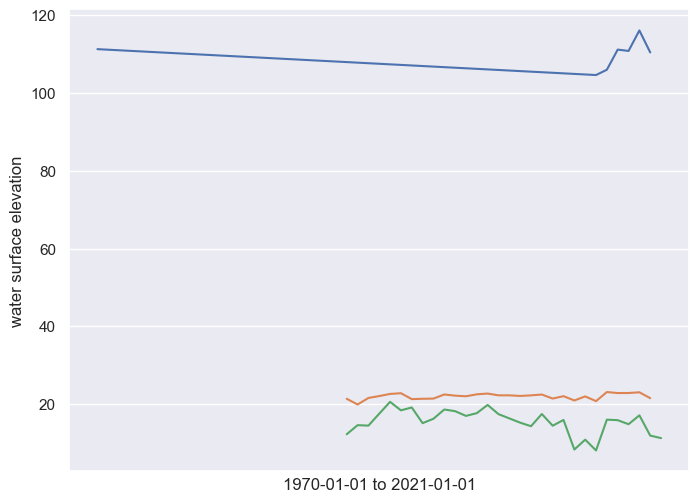

In [323]:

plt.xticks([])
plt.ylabel('water surface elevation')
plt.plot(get_mst_by_month(df[df['STATION'] == '21N02E26E005M'], '01')['MSMT_DATE'], get_mst_by_month(df[df['STATION'] == '21N02E26E005M'], '01')['WSE'])
plt.plot(get_mst_by_month(df[df['STATION'] == '09N03E08C001M'], '01')['MSMT_DATE'], get_mst_by_month(df[df['STATION'] == '09N03E08C001M'], '01')['WSE'])
plt.plot(get_mst_by_month(df[df['STATION'] == '09N03E08C003M'], '01')['MSMT_DATE'], get_mst_by_month(df[df['STATION'] == '09N03E08C003M'], '01')['WSE'])
plt.xlabel(get_mst_by_month(df[df['STATION'] == '21N02E26E005M'], '01')['MSMT_DATE'].iloc[0] + ' to ' + get_mst_by_month(df[df['STATION'] == '21N02E26E005M'], '01')['MSMT_DATE'].iloc[-1])
plt.show()


## Graping the water Levels 

View Water Levels over the lifetime of measurements. Only looking at places that have 28+ years of measurements.

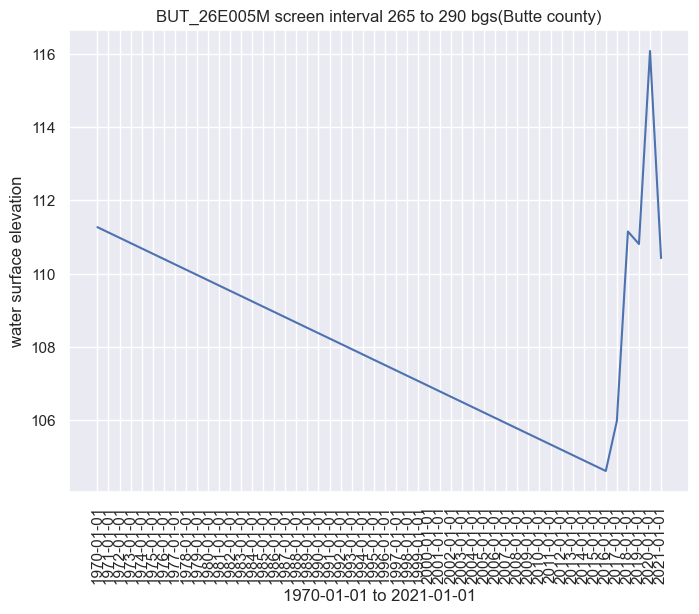

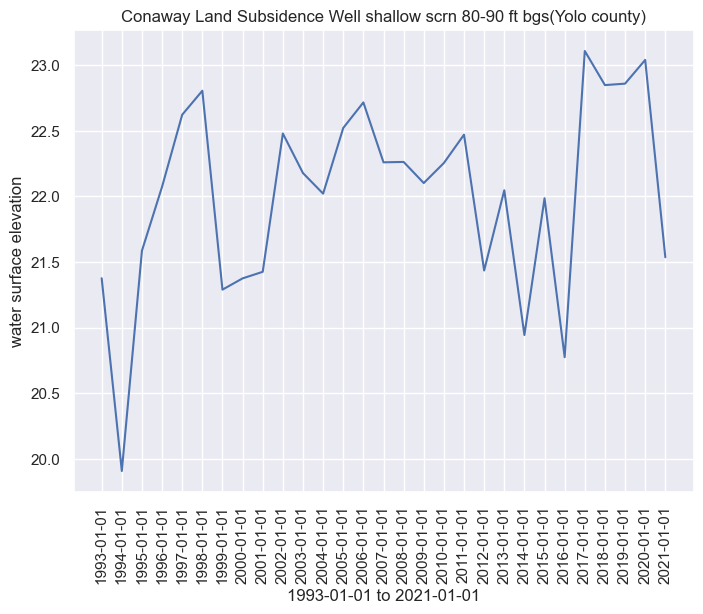

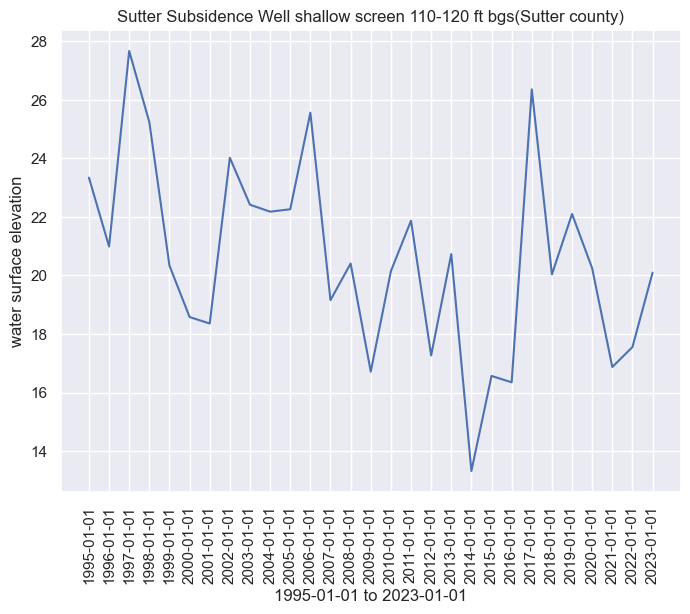

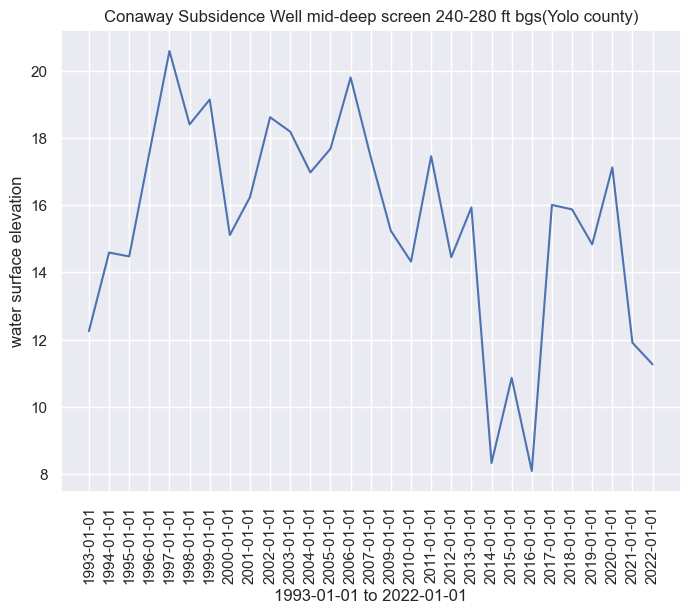

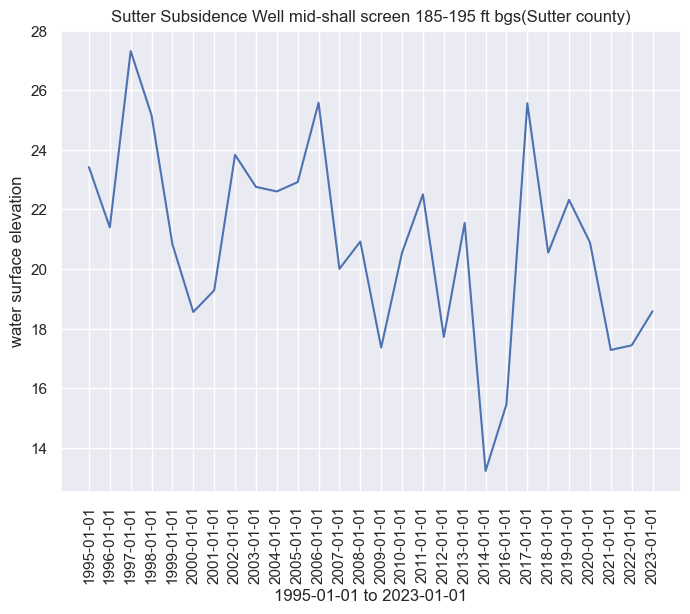

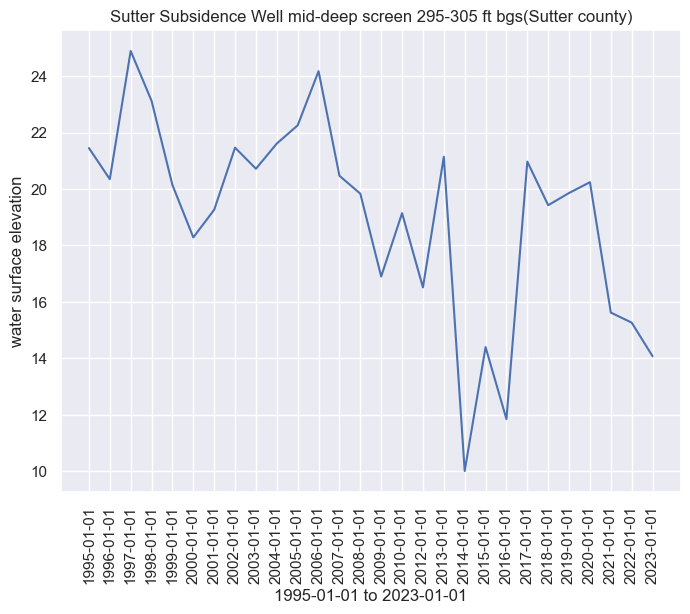

In [324]:
jan_meas = get_mst_by_month(df, '01').copy()

count = jan_meas.value_counts('STATION')


for station in count[count >= 28].index:
    st_info = stations[stations['STATION'] == station]
    stn = jan_meas[jan_meas['STATION'] == station]
    title = st_info['STNAME'].iloc[0] + '(' + st_info['COUNTY_NAME'].iloc[0] + ' county)'
    xlabel = stn['MSMT_DATE'].iloc[0] + ' to ' + stn['MSMT_DATE'].iloc[-1]
    plt.title(title)
    plt.plot(stn['MSMT_DATE'], stn['WSE'])
    plt.xticks(stn['MSMT_DATE'], rotation='vertical')
    plt.ylabel('water surface elevation')
    plt.xlabel(xlabel)
    plt.show()

## Preliminary work on machine learning to make predictions

We are going to use the `jan_meas` variable to perform the predictions

### Convert MSMT_Date to Timestamp

In [325]:
jan_meas = get_mst_by_month(df, '01').copy()

jan_meas['MSMT_TIMESTAMP'] = pd.to_datetime(jan_meas['MSMT_DATE'], format='%Y-%m-%d').astype(int)
jan_meas['STATION_IDX'] = jan_meas.apply(lambda x: stations[stations['STATION'] == x['STATION']].index[0] if len(stations[stations['STATION'] == x['STATION']].index) > 0 else None, axis=1)

In [326]:

print(jan_meas.describe())

           WLM_RPE   WLM_RPE_QC      WLM_GSE   WLM_GSE_QC      RPE_WSE  \
count  5527.000000  5527.000000  5527.000000  5527.000000  5527.000000   
mean    338.991956     8.713950   337.128489     8.323865    32.716033   
std     980.322020    24.396564   980.222089    24.117347    31.265123   
min      -0.570000     1.000000    -3.170000     1.000000   -11.806000   
25%      42.810000     1.000000    41.755000     1.000000    11.733500   
50%     125.900000     1.000000   125.400000     1.000000    23.018000   
75%     206.430000     1.000000   204.430000     1.000000    42.454000   
max    5495.260000   130.000000  5492.010000   130.000000   241.365000   

        RPE_WSE_QC      GSE_WSE   GSE_WSE_QC          WSE       WSE_QC  \
count  5527.000000  5527.000000  5527.000000  5527.000000  5527.000000   
mean      1.724082    30.852565     9.279175   306.275926     9.250226   
std       7.206989    31.344315    25.061900   982.073715    25.065672   
min       1.000000   -14.606000     1

In [327]:
# for repeatability
np.random.seed(42)   

predictors = ['MSMT_TIMESTAMP', 'STATION_IDX']
target = 'WSE'

X = jan_meas[predictors].values
y = jan_meas[target].values

# Split the data into training and test sets, and scale
scaler = StandardScaler()

# unscaled version (note that scaling is only used on predictor variables)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [328]:
print(X_train.shape)
print(X_train[:3])

(3868, 2)
[[1262304000000000000                 329]
 [1514764800000000000                 304]
 [1388534400000000000                  45]]


In [329]:
def rmse(predicted, actual):
    return np.sqrt(((predicted - actual)**2).mean())

In [330]:
reg = KNeighborsRegressor(algorithm='brute')
reg.fit(X_train, y_train)
predict = reg.predict(X_test)
RMSE = rmse(predict, y_test)
print('test RMSE, default hyperparameters: ', RMSE)

test RMSE, default hyperparameters:  1112.9642544204328


In [331]:
def get_train_test_rmse(regr, X_train, X_test, y_train, y_test):
    regr.fit(X_train, y_train)
    predict = regr.predict(X_test)
    rmse_te = rmse(predict, y_test)
    
    regr.fit(X_train, y_train)
    predict = regr.predict(X_train)
    rmse_tr = rmse(predict, y_train)
    return rmse_tr, rmse_te

In [332]:
n = 30
test_rmse = []
train_rmse = []
ks = np.arange(1, n+1, 2)
for k in ks:
    print(k, ' ', end='')
    regr = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
    rmse_tr, rmse_te = get_train_test_rmse(regr, X_train, X_test, y_train, y_test)
    train_rmse.append(rmse_tr)
    test_rmse.append(rmse_te)
print('done')

1  3  5  7  9  11  13  15  17  19  21  23  25  27  29  done


In [333]:
def get_best(ks, rmse):
    min_k = 1
    min = np.array(rmse)[0]
    for idx in range(len(ks)):
        if np.array(rmse)[idx] < min:
            min_k = ks[idx]
            min = np.array(rmse)[idx]
    return min_k, min

best_k, best_rmse = get_best(ks, test_rmse)
print('best k = {}, best test RMSE: {:0.1f}'.format(best_k, best_rmse))

best k = 29, best test RMSE: 998.5


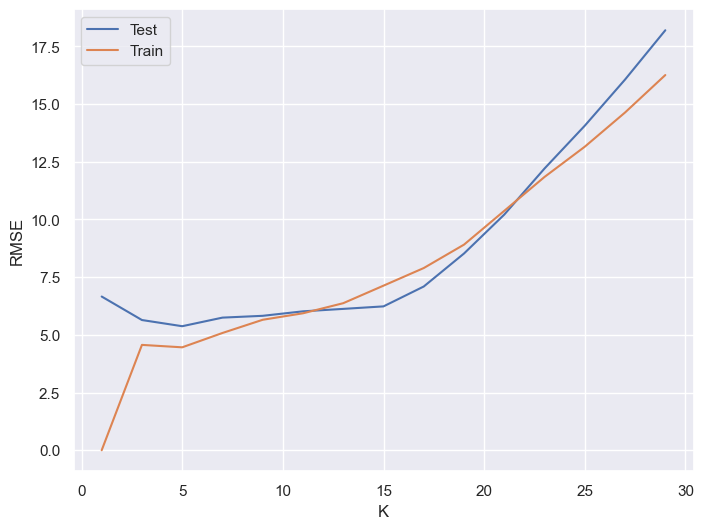

In [352]:
plt.plot(ks, test_rmse, label='Test')
plt.plot(ks, train_rmse, label='Train')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.legend()
plt.show()

## Comments

So far the training data does not look quite right. Could be from the cyclic data or that the index/timestamp predictors do not fit this model well. It could also be because the data is somewhat erratic. 

## Testing Unscaled vs Scaled

### Unscaled knn regressor

1  3  5  7  9  11  13  15  17  19  21  23  25  27  29  done
best k = 21, best test RMSE: 77.5


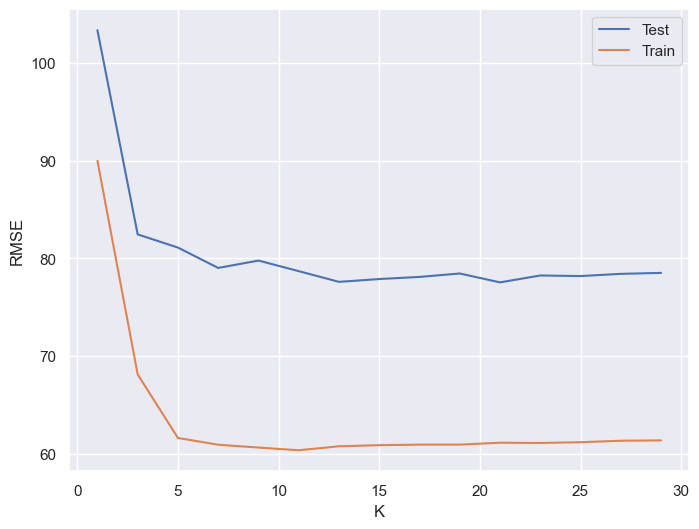

In [402]:
jan_meas = get_mst_by_month(df, '01').copy()
jan_meas = jan_meas[jan_meas['STATION'].map(jan_meas['STATION'].value_counts()) > 20]
jan_meas['MSMT_TIMESTAMP'] = pd.to_datetime(jan_meas['MSMT_DATE'], format='%Y-%m-%d').astype(int)
jan_meas['STATION_IDX'] = jan_meas.apply(lambda x: stations[stations['STATION'] == x['STATION']].index[0] if len(stations[stations['STATION'] == x['STATION']].index) > 0 else None, axis=1)

predictors = ['MSMT_TIMESTAMP', 'STATION_IDX']
target = 'WSE'

X = jan_meas[predictors].values
y = jan_meas[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

n = 30
test_rmse = []
train_rmse = []
ks = np.arange(1, n+1, 2)
for k in ks:
    print(k, ' ', end='')
    regr = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
    rmse_tr, rmse_te = get_train_test_rmse(regr, X_train, X_test, y_train, y_test)
    train_rmse.append(rmse_tr)
    test_rmse.append(rmse_te)
print('done')
best_k, best_rmse = get_best(ks, test_rmse)
print('best k = {}, best test RMSE: {:0.1f}'.format(best_k, best_rmse))

plt.plot(ks, test_rmse, label='Test')
plt.plot(ks, train_rmse, label='Train')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.legend()
plt.show()

### Scaled knn regressor

WSE_QC
1    81
dtype: int64
1  3  5  7  9  11  13  15  17  19  21  23  25  27  29  done
best k = 9, best test RMSE: 6.5


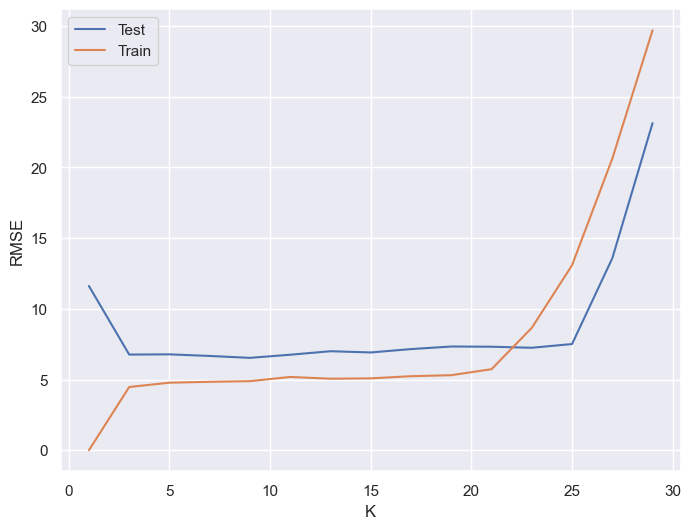

In [403]:
jan_meas = get_mst_by_month(df, '01').copy()
# jan_meas = df.copy()
jan_meas = jan_meas[jan_meas['STATION'].map(jan_meas['STATION'].value_counts()) > 20]
jan_meas = jan_meas[jan_meas['WSE_QC'] == 1]

print(jan_meas.value_counts('WSE_QC'))

jan_meas['MSMT_TIMESTAMP'] = pd.to_datetime(jan_meas['MSMT_DATE'], format='%Y-%m-%d').astype(int)
jan_meas['STATION_IDX'] = jan_meas.apply(lambda x: stations[stations['STATION'] == x['STATION']].index[0] if len(stations[stations['STATION'] == x['STATION']].index) > 0 else None, axis=1)

predictors = ['MSMT_TIMESTAMP', 'STATION_IDX']
target = 'WSE'

X = jan_meas[predictors].values
y = jan_meas[target].values

scaler = StandardScaler()

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

n = 30
test_rmse = []
train_rmse = []
ks = np.arange(1, n+1, 2)
for k in ks:
    print(k, ' ', end='')
    regr = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
    rmse_tr, rmse_te = get_train_test_rmse(regr, X_train, X_test, y_train, y_test)
    train_rmse.append(rmse_tr)
    test_rmse.append(rmse_te)
print('done')
best_k, best_rmse = get_best(ks, test_rmse)
print('best k = {}, best test RMSE: {:0.1f}'.format(best_k, best_rmse))

plt.plot(ks, test_rmse, label='Test')
plt.plot(ks, train_rmse, label='Train')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.legend()
plt.show()